#**Training d-DNN and e-DNNs using CPR coincidences over the land**

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import h5py
import os

## **1. Data**

### **1.1 Data Loading and Organizing**

In [ ]:
f = h5py.File('Data/Dictionaries/Dic_CPR_land.mat','r')
list(f.keys())

['X_land_trn_detection',
 'X_land_trn_retrieval',
 'X_land_tst_detection',
 'X_land_tst_retrieval',
 'y_land_trn_detection',
 'y_land_trn_retrieval',
 'y_land_tst_detection',
 'y_land_tst_retrieval']

In [ ]:
X1_trn_detection = np.transpose(f['X_land_trn_detection'])
y_trn_detection = np.transpose(f['y_land_trn_detection'])
X1_tst_detection = np.transpose(f['X_land_tst_detection'])
y_tst_detection = np.transpose(f['y_land_tst_detection'])

X1_trn_retrieval = np.transpose(f['X_land_trn_retrieval'])
y_trn_retrieval = np.transpose(f['y_land_trn_retrieval'])
X1_tst_retrieval = np.transpose(f['X_land_tst_retrieval'])
y_tst_retrieval = np.transpose(f['y_land_tst_retrieval'])

In [ ]:
X1_trn_detection.astype('float64')
X1_tst_detection.astype('float64')
y_trn_detection.astype('int64')
y_tst_detection.astype('int64')

X1_trn_retrieval.astype('float64')
X1_tst_retrieval.astype('float64')
y_trn_retrieval.astype('float64')
y_tst_retrieval.astype('float64');

### **1.2 Data Normalizing**

The input features for training have different ranges and units, therefore they need to be scaled to make the flow of the gradient decsent smooth and help the algorithm quickly reaches the optimal point of the cost function. Without scaling features, the algorithm may be biased toward those features which have larger magnitues. We used the following standardization:

$X_i^{\prime} = \frac{X_i - \mu}{σ}$

In the above equation $X_i^{\prime}$ is the scaled feature, $μ$ is the mean, and $σ$ is the standard deviation of the feature. In the next cell, we implement this scaling for the data sets.

In [ ]:
mean_detection = X1_trn_detection.mean(axis=0)
X2_trn_detection = X1_trn_detection-mean_detection
std_detection = X1_trn_detection.std(axis=0)
X_trn_detection = X2_trn_detection/std_detection
X2_tst_detection = X1_tst_detection-mean_detection
X_tst_detection = X2_tst_detection/std_detection

mean_retrieval = X1_trn_retrieval.mean(axis=0)
X2_trn_retrieval = X1_trn_retrieval-mean_retrieval
std_retrieval = X1_trn_retrieval.std(axis=0)
X_trn_retrieval = X2_trn_retrieval/std_retrieval
X2_tst_retrieval = X1_tst_retrieval-mean_retrieval
X_tst_retrieval = X2_tst_retrieval/std_retrieval

To show that the labels are balanced in the training and test set, the number of snowfall, rainfall and no precipitation lables is printed in the next cell.

In [ ]:
print('***Training Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_train = np.zeros([y_trn_detection.shape[0],1])

for i in range(len(X_trn_detection)):
    label = y_trn_detection[i]
    if label==5:
        n_snow+=1
        t_train[i]=2
    if label==3:
        n_rain+=1  
        t_train[i]=1
    if label==0:
        n_clear+=1
        t_train[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Testing Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_test = np.zeros([y_tst_detection.shape[0],1])

for i in range(len(X_tst_detection)):
    label = y_tst_detection[i]
    if label==5:
        n_snow+=1
        t_test[i]=2
    if label==3:
        n_rain+=1  
        t_test[i]=1
    if label==0:
        n_clear+=1
        t_test[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

***Training Dataset:

Num. of snowfall: 54466
Num. of rainfall: 54601
Num. of clear-sky: 108770

***Testing Dataset:

Num. of snowfall: 23338
Num. of rainfall: 23203
Num. of clear-sky: 46816


In [ ]:
from tensorflow.keras.utils import to_categorical

t_trn_detection = to_categorical(t_train)
t_tst_detection = to_categorical(t_test)

# **2. Training the networks**


### **2.1 - Detection Network (d-DNN)**

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, Sequential

In [ ]:
# Defining the architecture of the d-DNN network which has 6 layers and 30 hidden units in each layer.

# Parameters
hidden_units = 30
dropout = 0

# Detection Module
model_detection = Sequential()

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(3))
model_detection.add(Activation('softmax'))

In [ ]:
# Compiling the model by defining the loss function and learning rate.

model_detection.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics= [tf.keras.metrics.Recall()])

In [ ]:
# Defining the callback list for early stoping and saving the model.
from tensorflow import keras
callbacks_list = [
#     keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True,
    )    
]

In [ ]:
# Training the network (batch_size= 500, epoch = 500)
print('\nFitting DNN (Detection Module):\n')
batch_size1 = 500
history_detection = model_detection.fit(X_trn_detection, t_trn_detection, epochs=400,
                                validation_split=.2, batch_size = batch_size1,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Detection Module):

Epoch 1/400
349/349 [==============================] - 26s 19ms/step - loss: 0.8632 - recall_2: 0.2567 - val_loss: 0.6195 - val_recall_2: 0.4771
Epoch 2/400
349/349 [==============================] - 3s 9ms/step - loss: 0.4564 - recall_2: 0.7057 - val_loss: 0.3372 - val_recall_2: 0.8499
Epoch 3/400
349/349 [==============================] - 3s 8ms/step - loss: 0.2826 - recall_2: 0.8803 - val_loss: 0.2304 - val_recall_2: 0.8971
Epoch 4/400
349/349 [==============================] - 3s 8ms/step - loss: 0.2108 - recall_2: 0.9093 - val_loss: 0.1931 - val_recall_2: 0.9202
Epoch 5/400
349/349 [==============================] - 3s 8ms/step - loss: 0.1867 - recall_2: 0.9225 - val_loss: 0.1772 - val_recall_2: 0.9248
Epoch 6/400
349/349 [==============================] - 3s 8ms/step - loss: 0.1748 - recall_2: 0.9266 - val_loss: 0.1701 - val_recall_2: 0.9296
Epoch 7/400
349/349 [==============================] - 3s 9ms/step - loss: 0.1675 - recall_2: 0.9299 - val

Epoch 58/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1278 - recall_2: 0.9483 - val_loss: 0.1301 - val_recall_2: 0.9473
Epoch 59/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1274 - recall_2: 0.9484 - val_loss: 0.1302 - val_recall_2: 0.9473
Epoch 60/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1271 - recall_2: 0.9487 - val_loss: 0.1296 - val_recall_2: 0.9474
Epoch 61/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1268 - recall_2: 0.9484 - val_loss: 0.1309 - val_recall_2: 0.9462
Epoch 62/400
349/349 [==============================] - 2s 6ms/step - loss: 0.1265 - recall_2: 0.9487 - val_loss: 0.1295 - val_recall_2: 0.9469
Epoch 63/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1263 - recall_2: 0.9488 - val_loss: 0.1296 - val_recall_2: 0.9471
Epoch 64/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1260 - recall_2: 0.9489 - val_loss: 0.1290 - val_recall_2:

Epoch 115/400
349/349 [==============================] - 2s 6ms/step - loss: 0.1158 - recall_2: 0.9532 - val_loss: 0.1221 - val_recall_2: 0.9514
Epoch 116/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1156 - recall_2: 0.9536 - val_loss: 0.1214 - val_recall_2: 0.9518
Epoch 117/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1155 - recall_2: 0.9532 - val_loss: 0.1212 - val_recall_2: 0.9518
Epoch 118/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1153 - recall_2: 0.9535 - val_loss: 0.1215 - val_recall_2: 0.9511
Epoch 119/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1150 - recall_2: 0.9538 - val_loss: 0.1263 - val_recall_2: 0.9484
Epoch 120/400
349/349 [==============================] - 2s 6ms/step - loss: 0.1150 - recall_2: 0.9534 - val_loss: 0.1212 - val_recall_2: 0.9520
Epoch 121/400
349/349 [==============================] - 2s 6ms/step - loss: 0.1150 - recall_2: 0.9538 - val_loss: 0.1215 - val_re

349/349 [==============================] - 2s 5ms/step - loss: 0.1012 - recall_2: 0.9602 - val_loss: 0.1153 - val_recall_2: 0.9567
Epoch 295/400
349/349 [==============================] - 2s 6ms/step - loss: 0.1012 - recall_2: 0.9605 - val_loss: 0.1149 - val_recall_2: 0.9572
Epoch 296/400
349/349 [==============================] - 2s 6ms/step - loss: 0.1009 - recall_2: 0.9602 - val_loss: 0.1162 - val_recall_2: 0.9568
Epoch 297/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1010 - recall_2: 0.9604 - val_loss: 0.1145 - val_recall_2: 0.9576
Epoch 298/400
349/349 [==============================] - 2s 5ms/step - loss: 0.1008 - recall_2: 0.9603 - val_loss: 0.1153 - val_recall_2: 0.9564
Epoch 299/400
349/349 [==============================] - 2s 6ms/step - loss: 0.1008 - recall_2: 0.9606 - val_loss: 0.1189 - val_recall_2: 0.9558
Epoch 300/400
349/349 [==============================] - 2s 6ms/step - loss: 0.1009 - recall_2: 0.9604 - val_loss: 0.1160 - val_recall_2: 0.9569

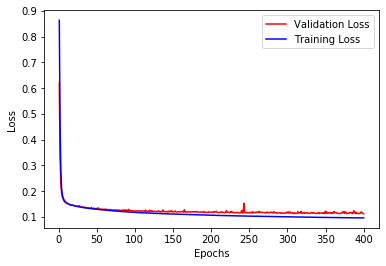

In [ ]:
# Plotting the variation of loss function on both training and validation set: 

import matplotlib.pyplot as plt
val_loss = history_detection.history["val_loss"]
loss = history_detection.history["loss"]

epochs = range(1, 401)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Testing the trained network over the testset.
predictions_label = model_detection.predict(X_tst_detection)

# Using argmax function to select the label with the highest probability.
y_pred = np.zeros([len(X_tst_detection),1])
for i in range(len(X_tst_detection)):
    y_pred[i,0] = np.argmax(predictions_label[i])

### Metrics

In [ ]:
### Detection Module

n_cc=1
n_cs=1
n_cr=1
n_sc=1
n_ss=1
n_sr=1
n_rc=1
n_rs=1
n_rr=1

precip_c= 0
precip_r= 1
precip_s= 2

for i in range(len(X_tst_detection)):
    label_predict = y_pred[i]
    label_actual = t_test[i]
    if label_predict==precip_c and label_actual==precip_c:
        n_cc+=1
    if label_predict==precip_s and label_actual==precip_s:
        n_ss+=1
    if label_predict==precip_r and label_actual==precip_r:
        n_rr+=1 
    if label_predict==precip_c and label_actual==precip_s:
        n_cs+=1
    if label_predict==precip_c and label_actual==precip_r:
        n_cr+=1
    if label_predict==precip_s and label_actual==precip_c:
        n_sc+=1
    if label_predict==precip_s and label_actual==precip_r:
        n_sr+=1  
    if label_predict==precip_r and label_actual==precip_c:
        n_rc+=1
    if label_predict==precip_r and label_actual==precip_s:
        n_rs+=1        
        
#Snow
TP_s = n_ss
TN_s = n_cc+n_cr+n_rc+n_rr
FP_s = n_sc+n_sr
FN_s = n_cs+n_rs

precision_s = TP_s/(TP_s+FP_s)
acc_s = (TP_s+TN_s)/(TP_s+TN_s+FP_s+FN_s)
recall_s = TP_s/(TP_s+FN_s)
f1_score_s = (2*precision_s*recall_s)/(precision_s+recall_s)
FPR_s = FP_s/(FP_s+TN_s)

#Rain
TP_r = n_rr
TN_r = n_cc+n_cs+n_sc+n_ss
FP_r = n_rc+n_rs
FN_r = n_cr+n_sr

precision_r = TP_r/(TP_r+FP_r)
acc_r = (TP_r+TN_r)/(TP_r+TN_r+FP_r+FN_r)
recall_r = TP_r/(TP_r+FN_r)
f1_score_r = (2*precision_r*recall_r)/(precision_r+recall_r)
FPR_r = FP_r/(FP_r+TN_r) 

print('\n For Rainfall Detection Over Land:\n')
print('Precision: ',precision_r)
print('Accuracy: ',acc_r)
print('Recall (TPR): ',recall_r)
print('False Alarm (FPR): ',FPR_r)
print('\nF1 Score: ',f1_score_r)

print('----------------------------')
print('\n For Snwofall Detection Over Land:\n')
print('Precision: ',precision_s)
print('Accuracy: ',acc_s)
print('Recall (TPR): ',recall_s)
print('False Alarm (FPR): ',FPR_s)
print('\nF1 Score: ',f1_score_s)

#Model
TP = n_cc+n_ss+n_rr
FP = n_cs+n_cr+n_sc+n_sr+n_rc+n_rs
FN = n_sc+n_rc+n_cs+n_rs+n_cr+n_sr

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)

print('----------------------------')
print('\n For Model Detection Over Land:\n')
print('Precision: ',precision)
print('Recall (TPR): ',recall)
print('\nF1 Score: ',f1_score)


 For Rainfall Detection Over Land:

Precision:  0.9995261480141294
Accuracy:  0.9998607585446054
Recall (TPR):  0.9999138116785176
False Alarm (FPR):  0.00015678896205707118

F1 Score:  0.9997199422650209
----------------------------

 For Snwofall Detection Over Land:

Precision:  0.9073302790503956
Accuracy:  0.9595128691237428
Recall (TPR):  0.93337617823479
False Alarm (FPR):  0.03177527383859589

F1 Score:  0.920168954593453
----------------------------

 For Model Detection Over Land:

Precision:  0.9594057603119008
Recall (TPR):  0.9594057603119008

F1 Score:  0.9594057603119008


In [ ]:
model_detection.evaluate(X_tst_detection, t_tst_detection, batch_size = batch_size1)

187/187 [==============================] - 0s 2ms/step - loss: 0.1089 - recall_2: 0.9595


[0.1088700145483017, 0.9594660997390747]

## **2.2 - Estimation networks (e-DNN)**

In [6]:
from tensorflow.keras import backend
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred-y_true)))
    
def mean_absolute_error(y_true, y_pred):
        return backend.mean(backend.abs(y_pred-y_true))        

### **2.2.1 Snowfall retrieval**

In [ ]:
# Parameters
hidden_units = 60
dropout = 0

# LAND
model_retrieval = Sequential()

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(1))
model_retrieval.add(Activation('relu'))

In [ ]:
model_retrieval.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = root_mean_squared_error,
              metrics= mean_absolute_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Snow):\n')
batch_size2 = 500
history_retrieval = model_retrieval.fit(X_trn_retrieval, y_trn_retrieval, epochs=400,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)

In [ ]:
import matplotlib.pyplot as plt

val_loss = history_retrieval.history["val_loss"]
loss = history_retrieval.history["loss"]

epochs = range(1, 258)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_snow = model_retrieval.predict(X_tst_retrieval)

In [ ]:
model_retrieval.evaluate(X_tst_retrieval, y_tst_retrieval, batch_size = batch_size2)

# **3. Saving the models**

In [ ]:
import scipy
from scipy.io import savemat

model_detection.save('Models\CPR\Land\model_dtc',save_format='h5')
model_retrieval.save('Models\CPR\Land\model_snow',save_format='h5')

fp_CPR_land = 'Models/CPR/land/files_CPR_land.mat'
scipy.io.savemat(fp_CPR_land, {'mean_detection_CPR_land': mean_detection,'std_detection_CPR_land':std_detection,
                               'mean_snow_retrieval_CPR_land': mean_retrieval,'std_snow_retrieval_CPR_land':std_retrieval})